In [1]:
from collections import Counter

import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm # progress apply :)
tqdm.pandas()

from datetime import datetime
today=datetime.today().strftime('%Y-%m-%d')

%load_ext autoreload
%autoreload 2
def d(l):
    pd.set_option('display.max_colwidth', l)




In [5]:
new_articles=pd.read_excel("2025-04-26 Manual Annotation results_Inclusion.xlsx")[["ID","text"]]


In [7]:
# ensure that lists are read as list and not as strings
from ast import literal_eval
columns_to_convert=["texts","labels","retraction_counts","has_retraction","has_retraction_label"]
converters = {col: literal_eval for col in columns_to_convert}

#df=pd.read_csv("2025-04-03 PDF Import complete.csv",index_col=0, converters=converters, encoding='utf-8')
df=pd.read_json("2025-04-03 PDF Import complete.json")
#df["text"]=df["text"].apply(lambda x: " ".join(x))
df.dropna(subset="texts",inplace=True)

In [9]:
df.labels.explode().value_counts()

labels
text                   120744
section_header          21246
list_item               11386
caption                  2092
page_header               365
footnote                  314
formula                   192
checkbox_unselected        83
paragraph                  28
checkbox_selected           5
code                        4
Name: count, dtype: int64

In [11]:
from MyLib import labelfilter

# Apply the functions to create new columns
filtered_texts = df.apply(lambda row: labelfilter.filter_texts(row['texts'], row['retraction_counts']), axis=1)
neighboring_texts = df.apply(lambda row: labelfilter.get_neighboring_texts(row['texts'], row['retraction_counts']), axis=1)
texts_until_section_header = df.apply(lambda row: labelfilter.get_texts_until_section_header(row['texts'], row['labels'], row['retraction_counts']), axis=1)

for i in [df.texts, filtered_texts,neighboring_texts,texts_until_section_header]:
    print(i.str.len().mean())

55.03306366514246
1.737952866690116
6.58353851565248
3.442842068237777


In [13]:
df["text"]=neighboring_texts.apply(lambda x: " ".join(x))

In [15]:
print(df.shape)
df.drop_duplicates(subset="text",inplace=True)
print(df.shape)

(2843, 10)
(2084, 10)


In [17]:
import spacy
nlp = spacy.load("en_core_web_sm")

def extract_nouns(text):
    doc = nlp(text)
    results=[]
    for token in doc:
        # Check if the token is a noun
        if token.pos_ == "NOUN" or token.pos_ =="ADJ"or token.pos_ =="PROPN":

            if len(token.text)>2:
                results.append(token.lemma_)
    
    return results


# Assuming df_PDF is a pandas DataFrame and 'text' is a column in it
df["noun_adj"] = df["text"].progress_apply(extract_nouns)

100%|███████████████████████████████████████| 2084/2084 [01:00<00:00, 34.47it/s]


In [18]:
df["noun_adj"].explode().value_counts()[20:40]

noun_adj
more             1059
scientist         998
science           978
investigation     948
part              928
experiment        890
Science           855
same              849
group             841
surface           812
first             795
high              781
misconduct        748
large             745
small             732
system            725
editor            718
number            707
article           702
great             686
Name: count, dtype: int64

In [19]:
noun_adj_propn=df["noun_adj"].explode().drop_duplicates().to_list()
len(noun_adj_propn)

65458

# Academic Fields

In [21]:
#https://github.com/kyletscheer/academic-disciplines

df_academic_fields=pd.read_excel("2024-11-14 Academic Disciplines List.xlsx",index_col="ID")
print(df_academic_fields.Field.unique())

print(df_academic_fields.Domain.unique())
df_academic_fields.columns

[nan 'Performing Arts' 'Visual Arts' 'History' 'Languages and Literature'
 'Law' 'Philosophy' 'Anthropology' 'Economics' 'Geography'
 'Political Science' 'Psychology' 'Sociology' 'Social Work' 'Biology'
 'Chemistry' 'Earth Science' 'Space Sciences' 'Physics' 'Computer Science'
 'Mathematics' 'Business' 'Engineering and Technology'
 'Medicine and Health']
['Humanities' 'Social Sciences' 'Natural Sciences' 'Formal Sciences'
 'Applied Sciences']


Index(['Domain', 'Field', 'Category', 'Subcategory', 'Subject', 'Discipline'], dtype='object')

In [22]:
df_academic_fields['combined']= df_academic_fields[["Field",'Category', 'Subcategory', 'Subject', 'Discipline']].values.tolist()
df_academic_fields=pd.DataFrame(df_academic_fields.groupby("Field")["combined"].agg(lambda x: list(set(sum(x, [])))))

In [23]:
import regex as re
df_academic_fields['combined']=df_academic_fields['combined'].apply(lambda x: [re.sub(r' ?\((.*?)\) ?',"",i) for i in x if isinstance(i,str)])
df_academic_fields['combined']=df_academic_fields['combined'].apply(lambda x: [i for i in x if re.search(" of ",i)==None]) # remove philosophy of AI and taht shit
df_academic_fields['combined']

Field
Anthropology                  [Archaeology, Biological anthropology, Social ...
Biology                       [Forensic pathology, Biotechnology , Comparati...
Business                      [Business, Operations management, Business man...
Chemistry                     [Geochemistry, Agrochemistry, Flow chemistry, ...
Computer Science              [Wireless computing , Scientific visualization...
Earth Science                 [Geochemistry, Geodesy, Edaphology / Pedology ...
Economics                     [Economic systems, Ecological economics, Welfa...
Engineering and Technology    [Thermodynamics, Systems psychology, Power eng...
Geography                     [Geochemistry, Health geography, Palaeontology...
History                       [American history, Scientific history, Humanis...
Languages and Literature      [Syntax, Medieval literature, Phonetics, Poetr...
Law                           [Contract law, Corporations, Civil procedure, ...
Mathematics                   [Dem

In [24]:
all_jobs=", ".join(set(df_academic_fields['combined'].explode().dropna()))
all_jobs_propn=extract_nouns(all_jobs)
all_jobs_propn_reduced=set(all_jobs_propn) & set(noun_adj_propn)

len(all_jobs), len(all_jobs_propn_reduced)

(22024, 676)

In [25]:
len(all_jobs_propn_reduced)
df_academic_fields['combined']["Anthropology"]

extract_nouns(" ".join(df_academic_fields['combined']["Anthropology"]))

['Archaeology',
 'Biological',
 'anthropology',
 'Social',
 'anthropology',
 'linguistic',
 'anthropology',
 'Cultural',
 'anthropology',
 'anthropology']

In [26]:
import regex as re
pattern=re.compile("|".join(all_jobs_propn_reduced))

#exclude_pattern=re.compile("|".join(["real","^sciences?","^theory","^law","^studies","^time","methods","outline","scientific","free","world","age","non"]),re.IGNORECASE)

def check_if_relevant(text):
    if isinstance(text,list):
        text=[i for i in text if isinstance(i, str)]
        # If none of the pattern lemmata is in the string, then the job is not relevant.
        
        text = [job for job in text if re.search(pattern, job)]
        text = [re.sub(" or|,"," and",job) for job in text]
        text2=([job.split(" and ") for job in text  if " and "  in job ])
        text2=[j for i in text2 for j in i]

        text.extend(text2)
        #text=[i for i in text if re.search(exclude_pattern,i)==None]
        text=list(set(text))
    return text

df_academic_fields['combined_reduced']=df_academic_fields['combined'].apply(check_if_relevant)

In [27]:
df_academic_fields['combined_reduced']

Field
Anthropology                  [Archaeology, Biological anthropology, Social ...
Biology                       [Marine biology, Neuroethology, Forensic patho...
Business                      [Business, Operations management, Business man...
Chemistry                     [Geochemistry, Agrochemistry, Flow chemistry, ...
Computer Science              [Scientific visualization, Object database, Co...
Earth Science                 [Geochemistry, Edaphology / Pedology or Soil s...
Economics                     [Economic systems, Ecological economics, Welfa...
Engineering and Technology    [Thermodynamics, Systems psychology, Power eng...
Geography                     [Geochemistry, Health geography, Palaeontology...
History                       [American history, Scientific history, Ancient...
Languages and Literature      [Medieval literature, Poetry, Ancient literatu...
Law                           [Contract law, Civil procedure, Constitutional...
Mathematics                   [Alg

In [28]:
job_ext_dict={
    "y":["ists?","ers?","ians?", "ysts?","y"],
    "chemistry":["Chemists?"],
    "law":["legal scholars?","legal reseachers?","law scholars?"],
    "ics":["ists?","isists?","icians?","ics"], ## but lots of ethics
    " studies": [" scholars?", " researchers?"," scientists?"," studies"],
    " sciences": [" scholars?"," researchers?"," scientists?"," sciences"],
    "ine":  ["ists?","ine"],
    "ion":["ists?","ors?","ion"],
    "sition":["nists?","ners?","sition"],
    "design":["designers?","design researchers?","design"],
    "sis":["ysts?","ists?","sis researchers?","sis scientists?"],
    "engineering":["engineers?","engineering"],
    "programming":["programmers?"]}




def add_jobs(job_list):
    job_list=list(set(job_list))
    new_list=[]
    all_keys=re.compile("|".join([k+"$" for k in job_ext_dict.keys()]),flags=re.IGNORECASE)

    for job in job_list:
        important_key=re.search(all_keys,job)
        if important_key!=None:

            important_key=important_key.group().lower()
            #print(important_key)
            v=job_ext_dict[important_key]
            #print(re.match(all_keys,job))
            for v_item in v:
                #print(job, v_item,important_key)
                new_job=re.sub(important_key+"$", v_item, job, flags=re.IGNORECASE)
               # print(job,new_job)
                new_list.append(new_job)
        else:
            for i in ["students?","scholars?","researchers?","scientists?"]:
                new_job=f"{job} {i}"
                new_list.append(new_job)

        

    #job_list+=new_list
    #new_list+=job_list
    return new_list

df_academic_fields["combined_extended"]=df_academic_fields["combined_reduced"].apply(add_jobs)


In [29]:

all_jobs=df_academic_fields["combined_extended"].explode().dropna().drop_duplicates()
all_jobs_tuple_list = list(zip(all_jobs.index, all_jobs.values))

print(len(all_jobs.to_list()))
#all_jobs["Physics"].to_list()

3954


In [30]:
import regex as re

all_jobs_ext_regex= re.compile(r"\b(" + "|".join(all_jobs) + r")\b"+r"{i<=2:\s}(?b)(?e)", re.IGNORECASE)

def keyword_check(text, re_pattern):
    if isinstance(text,str):
        matches=re.findall(re_pattern,text)
        matches=[i for i in matches if i]
        return matches

df["all_jobs"]=df["text"].progress_apply(keyword_check, re_pattern=all_jobs_ext_regex)

#df_PDF["all_jobs"]=df_PDF["text"].progress_apply(keyword_check, re_pattern=all_jobs_regex)

100%|███████████████████████████████████████| 2084/2084 [00:35<00:00, 59.04it/s]


In [31]:
# Most common Job names in the corpus
df["all_jobs"].explode().str.title().value_counts()[:20]

all_jobs
Technology     256
Medicine       194
Biology        186
Physics        149
Evolution      107
Biologist       89
Engineering     83
Geology         71
Chemist         55
Physiology      55
Anatomy         51
Electricity     50
Biologists      45
Morphology      44
Chemists        38
Engineers       36
Surgery         36
Philosophy      34
Geologists      27
Mechanics       26
Name: count, dtype: int64

In [32]:
## fixed AMBIGUITY: Consider that the jobs can fit into multiple disciplines: if more than one discipline fits to the job --> ignore!

def lookup(s, lookups):
    matched_patterns = []  # Initialize an empty list to collect matches
    for pattern, value in lookups:
        if re.search(value, s, re.IGNORECASE):
            matched_patterns.append(pattern) # Append the pattern to the list if there's a match
    if len(matched_patterns)==1:
        return matched_patterns[0]  # Return the list of matched patterns
    else:
        return None

df["fields"] = df["all_jobs"].progress_apply(lambda x: [lookup(job, all_jobs_tuple_list) for job in x])


100%|███████████████████████████████████████| 2084/2084 [06:09<00:00,  5.64it/s]


<Axes: title={'center': 'academic fields (multiple per paper)'}, ylabel='count'>

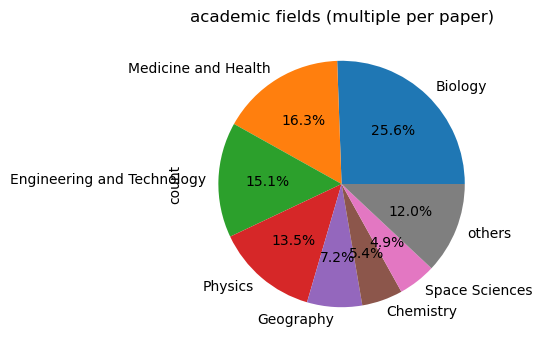

In [33]:
Disciplines2=df["fields"] .explode().value_counts()

top_x=7
top5=Disciplines2[:top_x]
top5["others"]=Disciplines2[top_x:].sum()
top5.plot.pie(figsize=(4,4), title="academic fields (multiple per paper)", autopct='%1.1f%%')

In [34]:

# Function to find the most common fields per paper
def most_common(fields):
    if not fields or all(f is None for f in fields):  # Handle empty or None lists
        return []
    
    # Count occurrences and find the max count
    counts = pd.Series(fields).value_counts()
    max_count = counts.max()
    
    # Return all fields with the max count
    return counts[counts == max_count].index.tolist()

# Apply the function to the 'fields' column
df['most_common_fields'] = df["fields"].apply(most_common)

In [35]:
df['most_common_fields']

Science113            [Physics, Chemistry]
Science116                              []
Science119                              []
Science149                       [Biology]
Science159                              []
                          ...             
Nature277                               []
Nature366                        [Physics]
Nature439                               []
Nature605     [Engineering and Technology]
Nature66                                []
Name: most_common_fields, Length: 2084, dtype: object

<Axes: title={'center': 'academic fields (one per paper)'}, ylabel='count'>

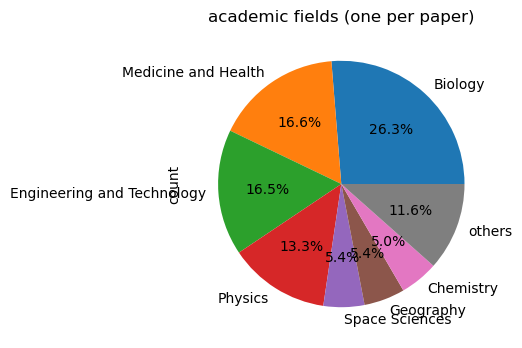

In [36]:
Disciplines3=df['most_common_fields'].explode().value_counts()


top_x=7
top5=Disciplines3[:top_x]
top5["others"]=Disciplines3[top_x:].sum()
top5.plot.pie(figsize=(4,4), title="academic fields (one per paper)", autopct='%1.1f%%')

In [37]:
df[["fields","all_jobs",'most_common_fields']].head()

,fields,all_jobs,most_common_fields
Science113,"[Physics, Chemistry]","[physician, pharmacologist]","[Physics, Chemistry]"
Science116,[],[],[]
Science119,[None],[economist],[]
Science149,"[Biology, Biology, Biology, Physics, Biology, ...","[biology, biologist, biologists, physics, biol...",[Biology]
Science159,[],[],[]


In [38]:
df_academic_fields["combined_extended_regex"]=df_academic_fields["combined_extended"].apply(lambda x:"|".join(x)).str.replace("||","|")

#academic_fields_dict_regex={k:re.compile("(" +v + ")" +r"{i<=2:\s}(?b)(?e)", re.IGNORECASE) for k,v in df_academic_fields["combined_extended_regex"].items()}
academic_fields_dict_regex={k:re.compile("\b"+v+"\b", re.IGNORECASE) for k,v in df_academic_fields["combined_extended_regex"].items()}

academic_fields_dict_regex['Physics']

regex.Regex('\x08Thermodynamists?|Thermodynamisists?|Thermodynamicians?|Thermodynamics|Plasma physists?|Plasma physisists?|Plasma physicians?|Plasma physics|Condensed matter physists?|Condensed matter physisists?|Condensed matter physicians?|Condensed matter physics|Medical physists?|Medical physisists?|Medical physicians?|Medical physics|Solid mechanists?|Solid mechanisists?|Solid mechanicians?|Solid mechanics|Electricitists?|Electriciters?|Electricitians?|Electricitysts?|Electricity|Statistical mechanists?|Statistical mechanisists?|Statistical mechanicians?|Statistical mechanics|Experimental physists?|Experimental physisists?|Experimental physicians?|Experimental physics|Quantum physists?|Quantum physisists?|Quantum physicians?|Quantum physics|Geophysics\xa0 students?|Geophysics\xa0 scholars?|Geophysics\xa0 researchers?|Geophysics\xa0 scientists?|Optists?|Optisists?|Opticians?|Optics|Mechanists?|Mechanisists?|Mechanicians?|Mechanics|Fluid dynamists?|Fluid dynamisists?|Fluid dynamicia

In [39]:
#fields_regex={k: re.compile("(" + "|".join(v) + ")" +r"{i<=2:\s}(?b)(?e)", re.IGNORECASE) for k, v in academic_fields.items()}
#fields_regex={k: re.compile("(" + "|".join(v) + ")" +r"{i<=2:\s}(?b)(?e)", re.IGNORECASE) for k, v in fields_dict.items()}


def keyword_check(text, re_pattern):
    if isinstance(text,str):
        matches=re.findall(re_pattern,text)

        return len(matches)

for k, v in academic_fields_dict_regex.items():
    print(k)
    df[k]=df["text"].progress_apply(keyword_check, re_pattern=v)

Anthropology


100%|█████████████████████████████████████| 2084/2084 [00:00<00:00, 6390.74it/s]


Biology


100%|██████████████████████████████████████| 2084/2084 [00:07<00:00, 280.88it/s]


Business


100%|█████████████████████████████████████| 2084/2084 [00:00<00:00, 8961.93it/s]


Chemistry


100%|██████████████████████████████████████| 2084/2084 [00:02<00:00, 874.25it/s]


Computer Science


100%|██████████████████████████████████████| 2084/2084 [00:11<00:00, 185.27it/s]


Earth Science


100%|█████████████████████████████████████| 2084/2084 [00:01<00:00, 1677.36it/s]


Economics


100%|██████████████████████████████████████| 2084/2084 [00:05<00:00, 347.87it/s]


Engineering and Technology


100%|██████████████████████████████████████| 2084/2084 [00:14<00:00, 139.51it/s]


Geography


100%|██████████████████████████████████████| 2084/2084 [00:05<00:00, 405.18it/s]


History


100%|██████████████████████████████████████| 2084/2084 [00:04<00:00, 474.22it/s]


Languages and Literature


100%|██████████████████████████████████████| 2084/2084 [00:03<00:00, 676.38it/s]


Law


100%|██████████████████████████████████████| 2084/2084 [00:02<00:00, 906.59it/s]


Mathematics


100%|██████████████████████████████████████| 2084/2084 [00:13<00:00, 155.21it/s]


Medicine and Health


100%|██████████████████████████████████████| 2084/2084 [00:09<00:00, 221.29it/s]


Performing Arts


100%|██████████████████████████████████████| 2084/2084 [00:03<00:00, 641.59it/s]


Philosophy


100%|██████████████████████████████████████| 2084/2084 [00:04<00:00, 520.61it/s]


Physics


100%|██████████████████████████████████████| 2084/2084 [00:02<00:00, 722.31it/s]


Political Science


100%|█████████████████████████████████████| 2084/2084 [00:00<00:00, 2207.25it/s]


Psychology


100%|██████████████████████████████████████| 2084/2084 [00:08<00:00, 239.36it/s]


Social Work


100%|█████████████████████████████████████| 2084/2084 [00:00<00:00, 6757.26it/s]


Sociology


100%|██████████████████████████████████████| 2084/2084 [00:09<00:00, 218.16it/s]


Space Sciences


100%|██████████████████████████████████████| 2084/2084 [00:02<00:00, 702.60it/s]


Visual Arts


100%|█████████████████████████████████████| 2084/2084 [00:01<00:00, 1696.98it/s]


In [40]:
Disciplines=df[df_academic_fields.index]
Disciplines

,Anthropology,Biology,Business,Chemistry,Computer Science,Earth Science,Economics,Engineering and Technology,Geography,History,...,Medicine and Health,Performing Arts,Philosophy,Physics,Political Science,Psychology,Social Work,Sociology,Space Sciences,Visual Arts
Science113,0,0,0,1,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
Science116,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Science119,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Science149,0,4,0,0,0,0,0,1,0,0,...,2,0,0,0,0,0,0,0,0,0
Science159,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Nature277,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
Nature366,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Nature439,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
Nature605,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
more_than_one_non_zero= Disciplines[(Disciplines != 0).sum(axis=1) > 1]
more_than_one_non_zero

## Only 323 papers mention disciplines

,Anthropology,Biology,Business,Chemistry,Computer Science,Earth Science,Economics,Engineering and Technology,Geography,History,...,Medicine and Health,Performing Arts,Philosophy,Physics,Political Science,Psychology,Social Work,Sociology,Space Sciences,Visual Arts
Science113,0,0,0,1,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
Science149,0,4,0,0,0,0,0,1,0,0,...,2,0,0,0,0,0,0,0,0,0
Science16,0,5,0,3,0,0,0,7,0,0,...,0,0,0,0,0,0,0,0,0,0
Science192,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
Science23,0,0,0,0,0,0,0,0,0,0,...,4,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Nature722,0,3,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
Nature730,0,2,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
Nature994,0,2,0,0,0,0,0,0,0,0,...,4,0,0,0,0,0,0,0,0,0
Nature158,0,1,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


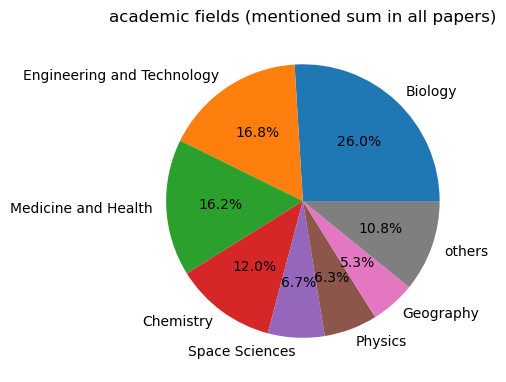

In [42]:
top_x=7

top5=Disciplines.sum().sort_values(ascending=False)[:top_x]
top5["others"]=Disciplines.sum().sort_values(ascending=False)[top_x:].sum()
top5.plot.pie(figsize=(5,5), title="academic fields (mentioned sum in all papers)", autopct='%1.1f%%')



plt.tight_layout()
plt.savefig(today+" disciplines pie.jpg",dpi=300)

# <5% attributed to others

In [43]:
Disciplines.sum().sort_values(ascending=False)

Biology                       927
Engineering and Technology    598
Medicine and Health           577
Chemistry                     428
Space Sciences                239
Physics                       225
Geography                     189
Philosophy                     86
Mathematics                    73
Languages and Literature       63
Psychology                     46
Sociology                      36
Earth Science                  29
Economics                      22
Computer Science               10
Anthropology                    9
History                         8
Political Science               5
Social Work                     0
Law                             0
Performing Arts                 0
Business                        0
Visual Arts                     0
dtype: int64

<Axes: title={'center': 'academic fields (only max one per paper)'}, ylabel='count'>

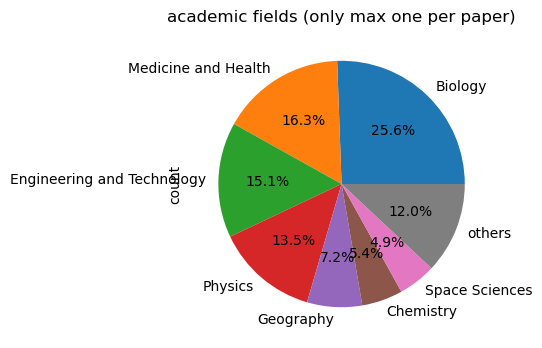

In [44]:

# look for the max values in each row
mxs = Disciplines.eq(Disciplines.max(axis=1), axis=0)
mxs_1=mxs[mxs.sum(axis=1)==1]

# join the column names of the max values of each row into a single string
labels = mxs_1.dot(mxs.columns + ', ').str.rstrip(', ')
labels=labels.str.split(", ")
labels=labels[labels.str.len()<7]



top_x=7
top5=Disciplines2[:top_x]
top5["others"]=Disciplines2[top_x:].sum()
top5.plot.pie(figsize=(4,4), title="academic fields (only max one per paper)", autopct='%1.1f%%')

# Country

In [46]:
## Import from her or use existing df

# ensure that lists are read as list and not as strings
#from ast import literal_eval
#columns_to_convert=["texts","labels","retraction_counts","has_retraction","has_retraction_label"]
#converters = {col: literal_eval for col in columns_to_convert}

#df=pd.read_csv("2025-02-23 PDF_import (docling - complete).csv",index_col=0, converters=converters)


In [47]:
df.labels.explode().value_counts()

labels
text                   91062
section_header         16898
list_item               8942
caption                 1762
page_header              329
footnote                 179
formula                  147
checkbox_unselected       64
paragraph                 28
code                       4
checkbox_selected          4
Name: count, dtype: int64

In [48]:
# filter text labels:
# 1. Filter by a list of allowed lables.
# 2. Filter by the method "till next section header"
allowed_lablels=["text","section_header","caption","paragraph","page_header","section_header"]

df_PDF=pd.DataFrame.from_records(df.apply(labelfilter.filter_texts_by_labels,allowed_labels=allowed_lablels,axis=1))
neighboring_texts = df_PDF.apply(lambda row: labelfilter.get_neighboring_texts(row['texts'], row['retraction_counts']), axis=1)
df_PDF["text"]=neighboring_texts.apply(lambda x: " ".join(x))


/var/folders/xb/hcrlz1px0q5byjc3wrssw2lm0000gn/T/ipykernel_13584/4226554866.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_PDF=pd.DataFrame.from_records(df.apply(labelfilter.filter_texts_by_labels,allowed_labels=allowed_lablels,axis=1))


In [49]:
df_PDF

,texts,labels,retraction_counts,text
0,[The Germans Trias i Pujol University Hospital...,"[caption, text, text, section_header, text, se...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","""If you, your spouse, your mother gets admitte..."
1,"[CAFFE', AURORA, CAFFE', IN DEPTH, Italy'sCovi...","[text, text, text, text, text, section_header,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","Still, the wealth of genomes is just a tiny sa..."
2,"[SCIENTIFICPUBLISHING, Elsevier to Editor: Cha...","[section_header, section_header, text, text, t...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Elsevier that your article should be permanent...
3,"[FEATURES, THE PREPRINT DILEMMA, Biologists ar...","[text, section_header, text, section_header, t...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",The episode has fueled calls for stricter comm...
4,"[VACCINEMYTHS, False: Vaccination can cause au...","[section_header, section_header, text, text, t...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",Several studies have shown that casting doubt ...
...,...,...,...,...
2079,"[RETRACTION, In view of the fact that the auth...","[section_header, text, text, text, text, text,...","[1, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",Toshiki Tajima is in theDepartment ofPhysicsan...
2080,"[Retraction, Quantum problems solved through g...","[section_header, section_header, text, text, t...","[1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Quantum problems solved through games Nature 5...
2081,"[RESEARCH, NEWS&VIEWS, RETRACTION, RETRACTEDAR...","[text, text, text, section_header, section_hea...","[0, 0, 1, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, ...",NEWS&VIEWS In view of the fact that the paper ...
2082,"[correspondence, concern was exclusively over ...","[section_header, text, text, text, section_hea...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",The independence of our editorial decision-mak...


In [50]:
demmonym=pd.read_excel("2024-11-14 demonym.xlsx")
# List from: https://www.thoughtco.com/the-names-of-nationalities-4088817

print("fix Demonyms: \n", demmonym.tail(3))
demmonym=dict(zip(demmonym.Demonym,demmonym.Country))
demmonym={k.replace(" or ","|").replace(", ","|").replace("/woman","").replace(" (collective)",""):v.split("/",1)[0] for k,v in demmonym.items()}

demmonym={f"({k})(s|ese|ish)?":v for k,v in demmonym.items()}

df_PDF["texts"]=df_PDF.texts.replace(demmonym,regex=True)


# tested with "American" & Americans --> "United States of America"

fix Demonyms: 
       Country             Demonym
190     Yemen  Yemeni or Yemenite
191    Zambia             Zambian
192  Zimbabwe          Zimbabwean


In [51]:
#!pip install geonamescache
#!pip install pycountry

import geonamescache
import pycountry

# Load the geonamescache data
gc = geonamescache.GeonamesCache()
cities_data = gc.get_cities()

# Minimal city population: 100.000

# Create a dictionary to map city names to countries
city_country_map = {city['name']: pycountry.countries.get(alpha_2=city['countrycode']).name for city in cities_data.values() 
                    if pycountry.countries.get(alpha_2=city['countrycode']) and city['population']>100000}

city_country_map2 = {}
city_city_map = {}
for city in cities_data.values():
    if city['population']>100000:
        for alt_name in city['alternatenames']:
            alt_name=alt_name.replace("The","")
            if len(alt_name)>3 and alt_name[0].isupper():
                if pycountry.countries.get(alpha_2=city['countrycode']):
                    city_city_map[alt_name]=city["name"]
                    city_country_map2[alt_name] = pycountry.countries.get(alpha_2=city['countrycode']).name

city_country_map.update(city_country_map2)


#refinements:

# Dr Baltimore --> remove Baltimore
# Human & Genes are not cities in this context
# Van --> most likely some Dutch Name artifact (Van Andel & Van Parijs) and not the Turkish City

drop_keys=["Human", "Genes", "Baltimore", "Van"]
for key in drop_keys:
    city_country_map.pop(key, None)
    city_country_map2.pop(key, None)
    city_city_map.pop(key, None)

In [52]:
from collections import defaultdict

# Alternative to keep all keys
Alternative_Names_list = defaultdict(list)

for k, v in city_city_map.items():
    Alternative_Names_list[v].append(k)
    

In [53]:
import regex as re
countries=list(set(city_country_map.values()))
cities=list(set(city_country_map.keys()))


# Prepare the regex pattern from the city names

city_names_pattern = r"\b(" + '|'.join(re.escape(city) for city in cities) + r")\b"
country_names_pattern = r"("+'|'.join(re.escape(country) for country in countries)+")" 

city_pattern = re.compile(city_names_pattern)
country_pattern = re.compile(country_names_pattern)

import regex as re

def keyword_check(text, re_pattern):
    if isinstance(text,str):
        matches=re.findall(re_pattern,text)
        return matches
    
df_PDF['contains_city']=df_PDF.text.progress_apply(keyword_check, re_pattern=city_names_pattern)
df_PDF['contains_country']=df_PDF.text.progress_apply(keyword_check, re_pattern=country_names_pattern)




100%|████████████████████████████████████| 2084/2084 [00:00<00:00, 10991.27it/s]


In [54]:
from collections import Counter
df_PDF['city']=df_PDF['contains_city'].apply(lambda x: [city_city_map[i] if i in city_city_map else i for i in x ])
df_PDF['country_from_city']=df_PDF['contains_city'].apply(lambda x: [city_country_map[i] if i in city_country_map else i for i in x ])
df_PDF["country_plus_city"]=df_PDF["country_from_city"]+df_PDF["contains_country"]
df_PDF['Most Common country'] = df_PDF["country_plus_city"].apply(lambda x: Counter(x).most_common()[0][0] if len(x)>0 else None)
df_PDF


,texts,labels,retraction_counts,text,contains_city,contains_country,city,country_from_city,country_plus_city,Most Common country
0,[The Germans Trias i Pujol University Hospital...,"[caption, text, text, section_header, text, se...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","""If you, your spouse, your mother gets admitte...",[Cambridge],[],[Cambridge],[United States],[United States],United States
1,"[CAFFE', AURORA, CAFFE', IN DEPTH, Italy'sCovi...","[text, text, text, text, text, section_header,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","Still, the wealth of genomes is just a tiny sa...","[Peking, Glasgow]",[China],"[Beijing, Glasgow]","[China, United Kingdom]","[China, United Kingdom, China]",China
2,"[SCIENTIFICPUBLISHING, Elsevier to Editor: Cha...","[section_header, section_header, text, text, t...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Elsevier that your article should be permanent...,[],[South Africa],[],[],[South Africa],South Africa
3,"[FEATURES, THE PREPRINT DILEMMA, Biologists ar...","[text, section_header, text, section_header, t...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",The episode has fueled calls for stricter comm...,"[New York, Boston, Cambridge, San Francisco]",[Bulgaria],"[New York City, Boston, Cambridge, San Francisco]","[United States, United States, United States, ...","[United States, United States, United States, ...",United States
4,"[VACCINEMYTHS, False: Vaccination can cause au...","[section_header, section_header, text, text, t...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",Several studies have shown that casting doubt ...,"[Atlanta, Wakefield]","[United Kingdom, Chad]","[Atlanta, Wakefield]","[United States, United Kingdom]","[United States, United Kingdom, United Kingdom...",United Kingdom
...,...,...,...,...,...,...,...,...,...,...
2079,"[RETRACTION, In view of the fact that the auth...","[section_header, text, text, text, text, text,...","[1, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",Toshiki Tajima is in theDepartment ofPhysicsan...,"[Tajima, Irvine]",[],"[Tajimi, Irvine]","[Japan, United States]","[Japan, United States]",Japan
2080,"[Retraction, Quantum problems solved through g...","[section_header, section_header, text, text, t...","[1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Quantum problems solved through games Nature 5...,[],[],[],[],[],None
2081,"[RESEARCH, NEWS&VIEWS, RETRACTION, RETRACTEDAR...","[text, text, text, section_header, section_hea...","[0, 0, 1, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, ...",NEWS&VIEWS In view of the fact that the paper ...,[],[],[],[],[],None
2082,"[correspondence, concern was exclusively over ...","[section_header, text, text, text, section_hea...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",The independence of our editorial decision-mak...,[Berkeley],[],[Berkeley],[United States],[United States],United States


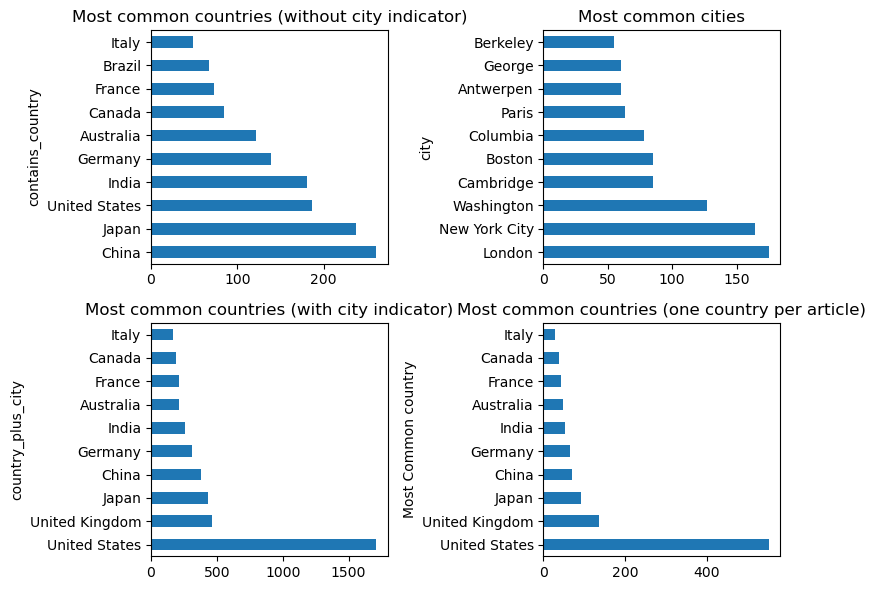

In [57]:

import matplotlib.pyplot as plt

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(8, 6))

# Plot 1: Most common countries - without city indicator
df_PDF['contains_country'].explode().dropna().value_counts()[:10].plot.barh(
    ax=axs[0, 0], title="Most common countries (without city indicator)"
)

# Plot 2: Most common cities
df_PDF['city'].explode().value_counts()[:10].plot.barh(
    ax=axs[0, 1], title="Most common cities"
)

# Plot 3: Most common countries, including city indicator
df_PDF["country_plus_city"].explode().value_counts()[:10].plot.barh(
    ax=axs[1, 0], title="Most common countries (with city indicator)"
)

# Plot 4: Most common countries, only one country per paper
df_PDF['Most Common country'].value_counts()[:10].plot.barh(
    ax=axs[1, 1], title="Most common countries (one country per article)"
)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

In [72]:
df["name"]=df.index

In [74]:
df_fields=df[["all_jobs", 'fields','most_common_fields',"name"]]
df_country=df_PDF[["contains_country","country_plus_city","Most Common country"]]
df_country.index=df.index
df_results=df_country.join(df_fields)

df_results.to_csv("2025-04-26 Country_fields results.csv")

In [ ]:
df_results